In [1]:
%matplotlib inline
import main
import spark_greedy
import matplotlib.pyplot as plt
import random
import math
import time
import networkx as nx
from functools import partial


#VM bs
import findspark
findspark.init()

from pyspark import SparkContext

In [2]:
sc = SparkContext("local", "test_run")

In [21]:
def node_swap(graph,total_nodes,current_nodes,swap_number):
    i = 0
    searching = True
    while searching:
    
        new_node = random.sample(total_nodes.difference(current_nodes),1)
        kept_nodes = random.sample(current_nodes,len(current_nodes) - swap_number)
        old_node = current_nodes.difference(kept_nodes)
        E1 = math.log(len(graph.edges(nbunch=old_node)))
        E2 = math.log(len(graph.edges(nbunch=new_node)))
        u = random.uniform(0,1)
        if u <= math.exp((E2 - E1)/0.25):
            return set(new_node) | set(kept_nodes)
            searching = False
        i += 1
        if i > 9:
            return set(new_node) | set(kept_nodes)
            searching = False
        
    '''
    new_nodes = set(random.sample(total_nodes.difference(current_nodes),swap_number))
    kept_nodes = set(random.sample(current_nodes,len(current_nodes) - swap_number))
    return new_nodes | kept_nodes
    '''
def imp_mcmc(graph,k,nodes_in=0,y=spark_greedy.spark_trials):
    
    if nodes_in == 0:
        all_nodes = set(graph.nodes())
    else:
        all_nodes = set(nodes_in)
    
    
    # graph broadcast
    g = sc.broadcast(graph)
    
    # partitions
    parts = 32
    
    # rdd
    rdd = sc.parallelize(range(0,parts),parts)
    
    # iteration variables
    i = 0
    j = 0
    
    # annealing parameters
    T = 1
    a = 0.9
    depth = 10
    N_tot = 128
    N = N_tot/parts
    swap = 1
    
    f = partial(y,rdd)
    
    nodes = set(random.sample(all_nodes,k))
    
    # Here E = activated nodes, we want to find max E (NOT min E)
    E1 = f(N,nodes,g.value,depth)['mean']
    max_E = E1
    temp_max_E = E1
    max_nodes = nodes
    temp_max_nodes = nodes
    accepted = []
    chain = 0

    while i < 10:
        
        start = time.time()

        if j > 49:
            T = T*a
            j = 0

        if chain > 5000:
            #N += 1
            T = 1
            chain = 0
            nodes = set(random.sample(all_nodes,k))
            E1 = f(N, nodes, g.value, depth)['mean']
            temp_max_E = E1
            temp_max_nodes = nodes
            print "chain reset"

        new_nodes = node_swap(graph,all_nodes,nodes,swap)
        E2 = f(N, new_nodes, g.value, depth)['mean']
        
        u = random.uniform(0,1)
        
        # Boltzman distribution
        if u <= math.exp((E2 - E1)/T):
            
            if E2 > max_E:
                max_E = E2
                max_nodes = new_nodes
                
            if E2 < temp_max_E:
                temp_max_E = E2
                chain = 0

            j += 1
            nodes = new_nodes
            E1 = E2

        else:
            chain += 1

        accepted.append(E1)
        i += 1
        
        print str(i) + ' done in ' + str(time.time() - start)
        print E1
        print nodes

    plt.plot(accepted)
    print max_nodes
    print max_E


In [16]:
NC_digraph = main.import_graph("nc_full.json")

0.110218048096
0.170822324967
1 done in 47.3789927959
8955.65278568
set([u'iTspEpMdqXGm0cNJsIBZwQ', u'9TI_3s-kFcFM7vmW794GlQ', u'YyL6IsdLutK5So0Dm6gJow'])
2 done in 60.8021628857
8966.50684778
set([u'4qrTj3MTqhvh8CvLUmBpmA', u'9TI_3s-kFcFM7vmW794GlQ', u'YyL6IsdLutK5So0Dm6gJow'])
3 done in 40.8690330982
8966.50684778
set([u'4qrTj3MTqhvh8CvLUmBpmA', u'9TI_3s-kFcFM7vmW794GlQ', u'YyL6IsdLutK5So0Dm6gJow'])
4 done in 48.6914451122
8966.50684778
set([u'4qrTj3MTqhvh8CvLUmBpmA', u'9TI_3s-kFcFM7vmW794GlQ', u'YyL6IsdLutK5So0Dm6gJow'])
5 done in 62.3215680122
8966.50684778
set([u'4qrTj3MTqhvh8CvLUmBpmA', u'9TI_3s-kFcFM7vmW794GlQ', u'YyL6IsdLutK5So0Dm6gJow'])
6 done in 39.8961639404
8996.07569816
set([u'nEVXBq0LIDQxd31GUUZ3Nw', u'YyL6IsdLutK5So0Dm6gJow', u'4qrTj3MTqhvh8CvLUmBpmA'])
7 done in 39.2412140369
8996.07569816
set([u'nEVXBq0LIDQxd31GUUZ3Nw', u'YyL6IsdLutK5So0Dm6gJow', u'4qrTj3MTqhvh8CvLUmBpmA'])
8 done in 39.2406110764
8996.07569816
set([u'nEVXBq0LIDQxd31GUUZ3Nw', u'YyL6IsdLutK5So0Dm6gJow'

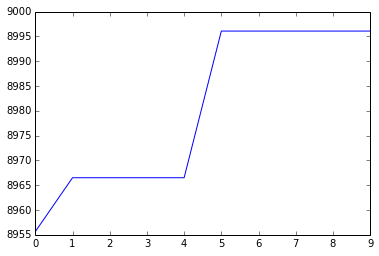

In [22]:
nodes = main.edge_count_pruner(NC_digraph,5)
imp_mcmc(NC_digraph,3,nodes_in=nodes)

set([u'NzWLMPvbEval0OVg_YDn4g'])
28.5928532229
197.243283987


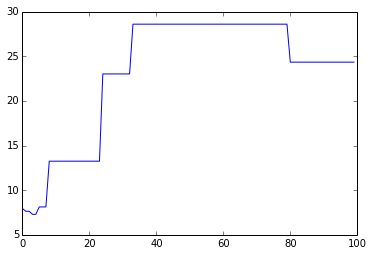

In [9]:
start = time.time()
imp_mcmc(NC_digraph,1)

print time.time() - start

In [ ]:
imp_mcmc(NC_digraph,3)

In [ ]:
imp_mcmc(NC_digraph,4)

In [ ]:
imp_mcmc(NC_digraph,5)

In [ ]:
sc.parallelize(range(0,8),32).getNumPartitions()

In [ ]:
start = time.time()
rdd = sc.parallelize(range(0,2),2)
x = [random.choice(NC_digraph.nodes())]
spark_greedy.spark_trials(rdd,2**13,x,NC_digraph)
print time.time() - start

In [ ]:
start = time.time()
rdd = sc.parallelize(range(0,4),4)
spark_greedy.spark_trials(rdd,2**12,x,NC_digraph)
print time.time() - start

In [ ]:
main.cascade_trials(2**14,x,NC_digraph)

In [ ]:
NC_full = main.import_graph('nc_full.json')
x = set([u'irgp7zoz5-wHG4DklEhzBw', u'Axjahugoqcfr6GTidue9cA', u'Fc8NYfCU59hFEyr59AA1BA', u'j-fQR6bLlELfTWtKple3LQ', u'Dxgd2ClL4N1HNjo1DEEmDw'])
print len(main.init_full_cascade(x,NC_full,10))

In [ ]:
k = 1
for g in nx.strongly_connected_component_subgraphs(NC_digraph):
    if len(g.nodes()) > 2:
        print "found " + str(k)
        ecc_arr = []
        for j in xrange(0,1000):
            node = random.choice(g.nodes())
            ecc_arr.append(nx.eccentricity(g,node))
        
        print max(ecc_arr)
        k += 1